In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.distance import geodesic
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Load the dataset
df = pd.read_csv(r"food_delivery\train.csv")  # Change to your actual filename

### 1. Importing the data

Preview the dataset, check data types, view basic summary statistics, and identify any missing values.

In [2]:
# Display the first few rows of the dataset
df.head()

# Summary info and data types
df.info()

# Basic statistics for numeric features
df.describe()

# Check for missing values
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

ID                             0
Delivery_person_ID             0
Delivery_person_Age            0
Delivery_person_Ratings        0
Restaurant_latitude            0
Restaurant_longitude           0
Delivery_location_latitude     0
Delivery_location_longitude    0
Order_Date                     0
Time_Orderd                    0
Time_Order_picked              0
Weatherconditions              0
Road_traffic_density           0
Vehicle_condition              0
Type_of_order                  0
Type_of_vehicle                0
multiple_deliveries            0
Festival                       0
City                           0
Time_taken(min)                0
dtype: int64

The data set has missing values labeled as "NaN" strings, so they are not counted as missing by the isna() method. These will be imputed during the data cleaning process.

### 2. Basic Data Cleaning

Cleans string columns, converts time fields to datetime format, and handles type conversions. This ensures all variables are usable in downstream modeling.

In [12]:
# Clean and prepare the data
df_clean = df.copy()

# Remove '(min) ' from Time_taken(min) and convert to int
df_clean['Time_taken(min)'] = df_clean['Time_taken(min)'].str.extract('(\d+)').astype(int)

# Convert ratings and age to numeric (coerce errors to NaN, then drop)
df_clean['Delivery_person_Ratings'] = pd.to_numeric(df_clean['Delivery_person_Ratings'], errors='coerce')
df_clean['Delivery_person_Age'] = pd.to_numeric(df_clean['Delivery_person_Age'], errors='coerce')

# Convert date/time fields
df_clean['Order_Date'] = pd.to_datetime(df_clean['Order_Date'], format='%d-%m-%Y', errors='coerce')
df_clean['Time_Orderd'] = pd.to_datetime(df_clean['Order_Date'].astype(str) + ' ' + df_clean['Time_Orderd'], errors='coerce')
df_clean['Time_Order_picked'] = pd.to_datetime(df_clean['Order_Date'].astype(str) + ' ' + df_clean['Time_Order_picked'], errors='coerce')

# Clean string fields
str_cols = df_clean.select_dtypes(include='object').columns
df_clean[str_cols] = df_clean[str_cols].apply(lambda x: x.str.strip())
df_clean['Weatherconditions'] = df_clean['Weatherconditions'].str.replace('conditions', '').str.strip()

# calculate the distance column in kilometers
df_clean['distance_km'] = ((df_clean['Restaurant_latitude'] - df_clean['Delivery_location_latitude'])**2 + 
                     (df_clean['Restaurant_longitude'] - df_clean['Delivery_location_longitude'])**2 )**0.5 * 111

# Impute numeric columns with median
num_cols = df_clean.select_dtypes(include='number').columns
df_clean[num_cols] = df_clean[num_cols].fillna(df_clean[num_cols].median())

# Impute categorical columns with mode
cat_cols = df_clean.select_dtypes(include='object').columns
for col in cat_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])
    
# Convert non-null Time_Orderd to seconds since midnight
valid_times = df_clean['Time_Orderd'].dropna().dt.hour * 3600 + df_clean['Time_Orderd'].dropna().dt.minute * 60 + df_clean['Time_Orderd'].dropna().dt.second

# Get the median time in seconds
median_seconds = int(valid_times.median())

# Convert median seconds back to a time string
hours = median_seconds // 3600
minutes = (median_seconds % 3600) // 60
seconds = median_seconds % 60
median_time_str = f"{hours:02d}:{minutes:02d}:{seconds:02d}"

# Impute missing Time_Orderd using the original Order_Date + median time
mask = df_clean['Time_Orderd'].isna()
df_clean.loc[mask, 'Time_Orderd'] = pd.to_datetime(
    df_clean.loc[mask, 'Order_Date'].dt.strftime('%Y-%m-%d') + ' ' + median_time_str,
    errors='coerce'
)

# Final check
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   ID                           45593 non-null  object        
 1   Delivery_person_ID           45593 non-null  object        
 2   Delivery_person_Age          45593 non-null  float64       
 3   Delivery_person_Ratings      45593 non-null  float64       
 4   Restaurant_latitude          45593 non-null  float64       
 5   Restaurant_longitude         45593 non-null  float64       
 6   Delivery_location_latitude   45593 non-null  float64       
 7   Delivery_location_longitude  45593 non-null  float64       
 8   Order_Date                   45593 non-null  datetime64[ns]
 9   Time_Orderd                  45593 non-null  datetime64[ns]
 10  Time_Order_picked            45593 non-null  datetime64[ns]
 11  Weatherconditions            45593 non-nu

### 3. Exploratory Data Analysis

Visualize distributions of delivery times and assess the influence of categorical variables like traffic density and weather.

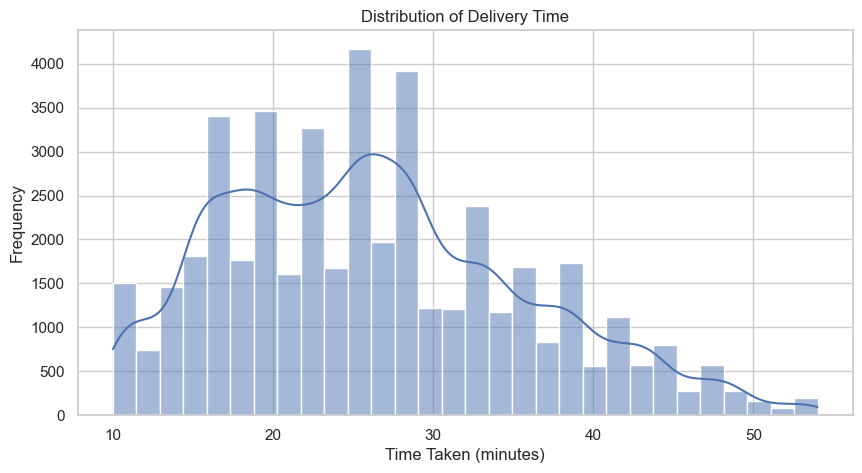

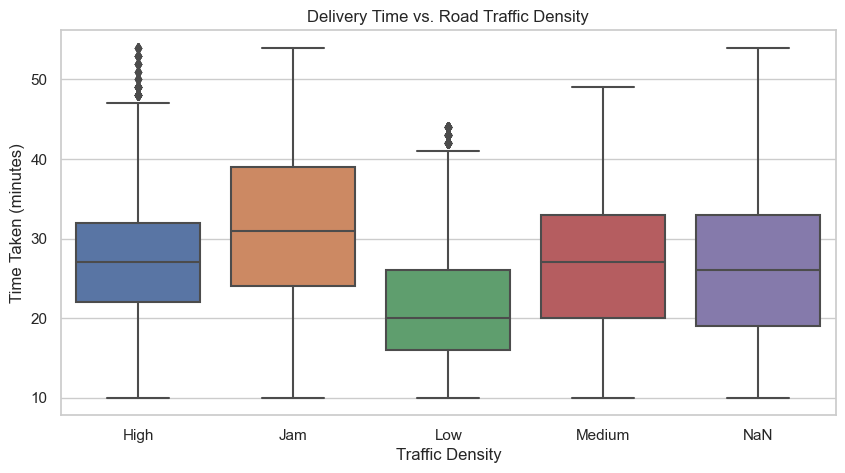

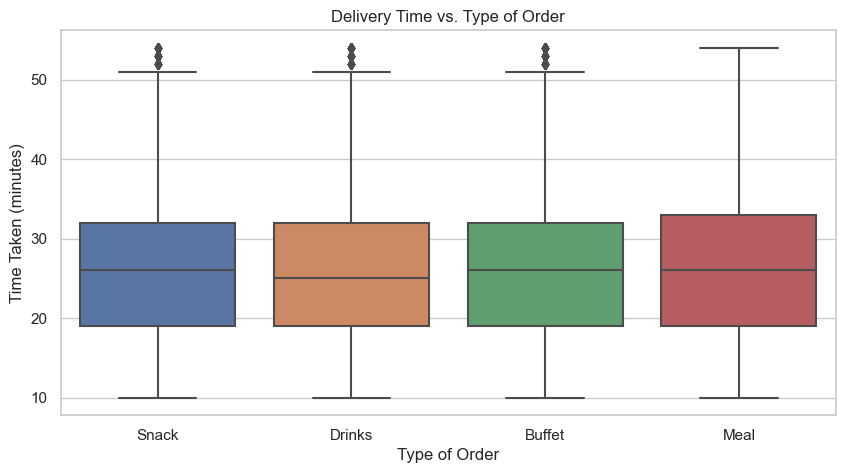

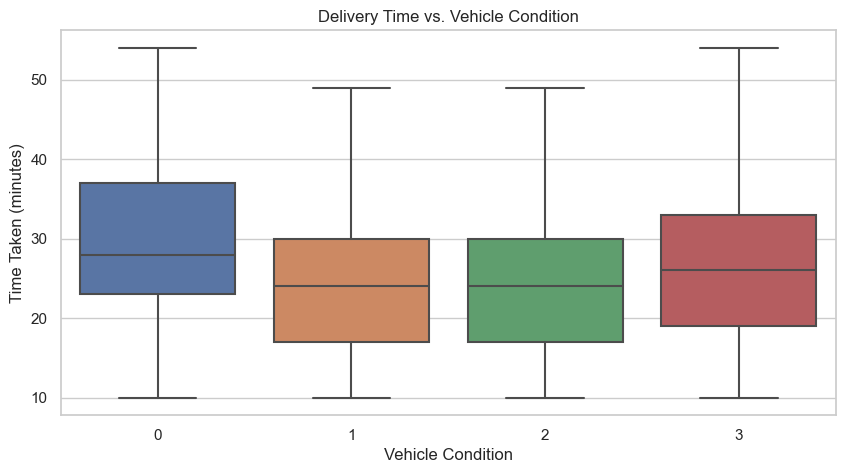

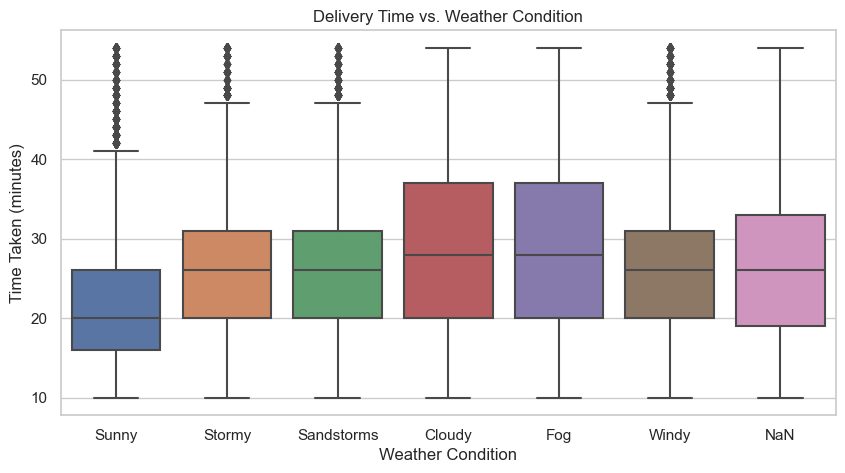

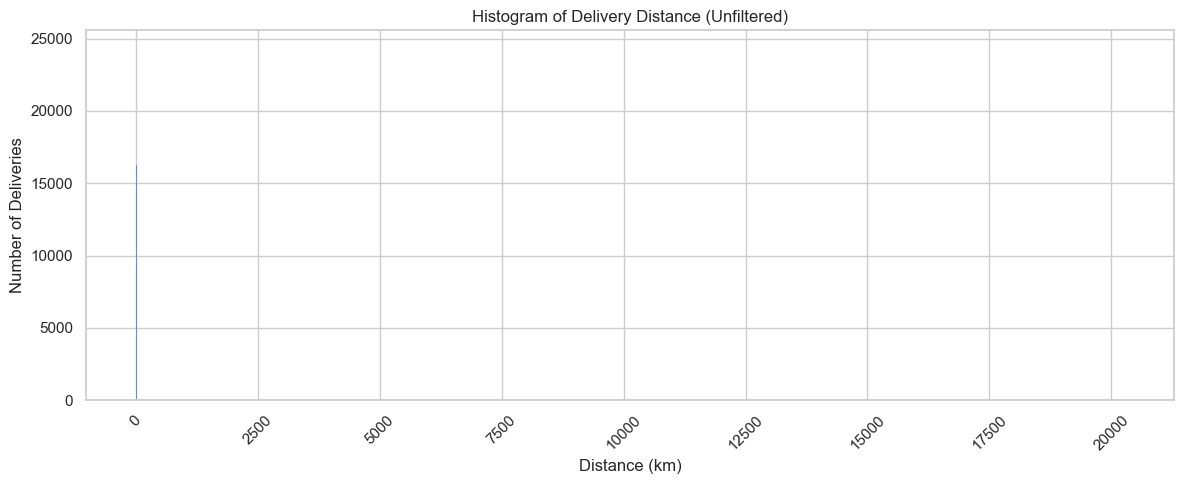

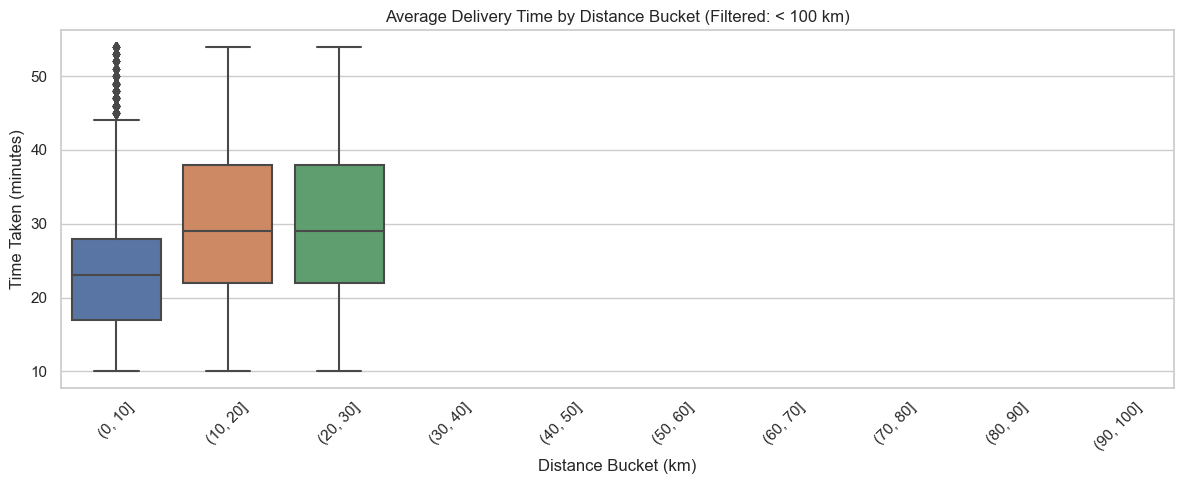

In [13]:
# Set plot theme
sns.set(style="whitegrid")

# Plot 1: Distribution of delivery time
plt.figure(figsize=(10, 5))
sns.histplot(df_clean['Time_taken(min)'], bins=30, kde=True)
plt.title("Distribution of Delivery Time")
plt.xlabel("Time Taken (minutes)")
plt.ylabel("Frequency")
plt.show()

# Plot 2: Boxplot of delivery time by traffic
plt.figure(figsize=(10, 5))
sns.boxplot(x='Road_traffic_density', y='Time_taken(min)', data=df_clean)
plt.title("Delivery Time vs. Road Traffic Density")
plt.xlabel("Traffic Density")
plt.ylabel("Time Taken (minutes)")
plt.show()

# Plot 3: Boxplot of delivery time by type of order
plt.figure(figsize=(10, 5))
sns.boxplot(x='Type_of_order', y='Time_taken(min)', data=df_clean)
plt.title("Delivery Time vs. Type of Order")
plt.xlabel("Type of Order")
plt.ylabel("Time Taken (minutes)")
plt.show()

# Plot 4: Boxplot of delivery time by vehicle condition
plt.figure(figsize=(10, 5))
sns.boxplot(x='Vehicle_condition', y='Time_taken(min)', data=df_clean)
plt.title("Delivery Time vs. Vehicle Condition")
plt.xlabel("Vehicle Condition")
plt.ylabel("Time Taken (minutes)")
plt.show()

# Plot 5: Boxplot of delivery time by weather condition
plt.figure(figsize=(10, 5))
sns.boxplot(x='Weatherconditions', y='Time_taken(min)', data=df_clean)
plt.title("Delivery Time vs. Weather Condition")
plt.xlabel("Weather Condition")
plt.ylabel("Time Taken (minutes)")
plt.show()

# Create 10-km distance buckets for unfiltered and filtered datasets
df_clean['distance_bucket'] = pd.cut(df_clean['distance_km'], bins=np.arange(0, df_clean['distance_km'].max() + 10, 10))

# Filter for realistic deliveries under 100 km and assign the same 10-km buckets
filtered_df = df_clean[df_clean['distance_km'] < 100].copy()
filtered_df['distance_bucket'] = pd.cut(filtered_df['distance_km'], bins=np.arange(0, 100 + 10, 10))

# Plot 6: histogram of distance for the full (unfiltered) dataset
plt.figure(figsize=(12, 5))
sns.histplot(data=df_clean, x='distance_km', bins=np.arange(0, df_clean['distance_km'].max() + 10, 10), kde=False)
plt.title("Histogram of Delivery Distance (Unfiltered)")
plt.xlabel("Distance (km)")
plt.ylabel("Number of Deliveries")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 7: average delivery time by distance for filtered data (< 100 km)
plt.figure(figsize=(12, 5))
sns.boxplot(data=filtered_df, x='distance_bucket', y='Time_taken(min)')
plt.title("Average Delivery Time by Distance Bucket (Filtered: < 100 km)")
plt.xlabel("Distance Bucket (km)")
plt.ylabel("Time Taken (minutes)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 📊 Exploratory Data Analysis – Key Insights

We explored how key features relate to delivery time, focusing on variability, trends, and data quality.

- **Delivery Time Distribution:** The distribution is right-skewed, with most deliveries completed within 15–30 minutes. This supports the use of robust error metrics like MAE during model evaluation.

- **Traffic:** Delivery time increases significantly with traffic congestion. There is an 11-minute median difference between “Low” and “Jam” conditions. Interestingly, “Medium” and “High” traffic levels show little to no difference, suggesting a non-linear relationship or inconsistent classification.

- **Weather:** Deliveries during sunny conditions are completed more quickly than in all other weather types. Strangely, cloudy and foggy conditions show higher median delivery times than stormy weather — potentially due to correlation between weather patterns and the region the delivery takes place in.

- **Vehicle Condition:** Only vehicles rated in the poorest condition (0) show a significant increase in delivery time. All other levels appear to have minimal effect, indicating that this feature may act more like a binary indicator than a continuous scale.

- **Distance and Dirty Data:** The unfiltered scatterplot of distance vs. time is distorted by extreme outliers — some deliveries show distances in the thousands of kilometers, likely due to erroneous coordinates. After filtering to distances under 100 km and binning into 10 km groups, a clear upward trend becomes visible. All deliveries occur under 30 km, suggesting this is the practical delivery boundary.

These findings confirm the value of filtering and engineered features — especially those related to distance, traffic, and time-based context.


### 4. Base Model

We build a baseline model using Random Forest regression. The model is trained on cleaned features and evaluated using R² and MAE. Feature importances are assessed to determine the most relevant features.

MAE: 3.16
R^2 Score: 0.82


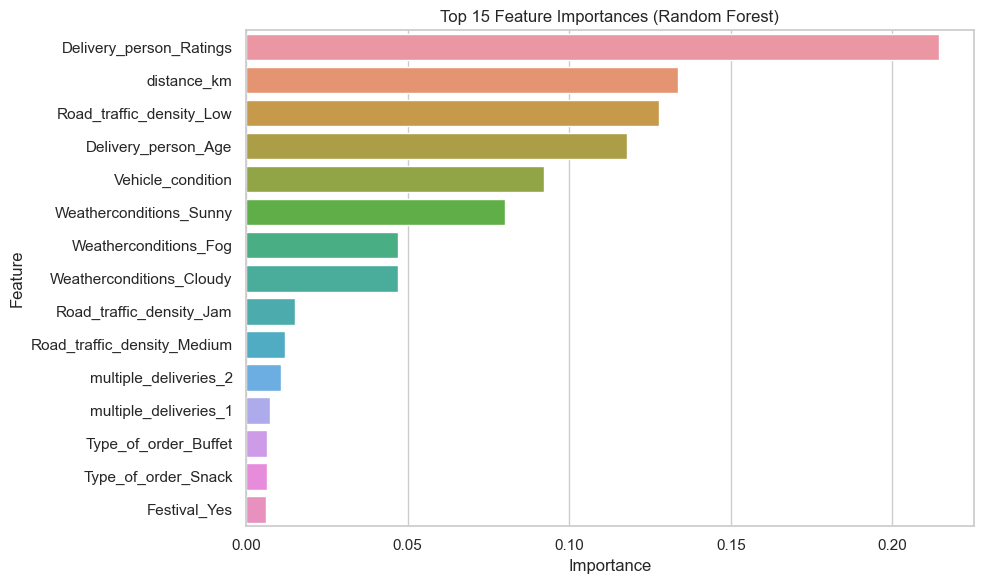

,Feature,Importance
33,Delivery_person_Ratings,0.214516
35,distance_km,0.133574
14,Road_traffic_density_Low,0.127887
32,Delivery_person_Age,0.118022
34,Vehicle_condition,0.092373
10,Weatherconditions_Sunny,0.080207
6,Weatherconditions_Fog,0.046949
5,Weatherconditions_Cloudy,0.046943
13,Road_traffic_density_Jam,0.015205
15,Road_traffic_density_Medium,0.011959


In [34]:
# Features and target
features = ['Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition',
            'multiple_deliveries', 'distance_km', 'Weatherconditions', 
            'Road_traffic_density', 'Type_of_order', 'Type_of_vehicle', 'City', 'Festival']
target = 'Time_taken(min)'

X = df_clean[features]
y = df_clean[target]

# Define preprocessing for categorical columns
categorical_features = ['multiple_deliveries', 'Weatherconditions', 'Road_traffic_density',
                        'Type_of_order', 'Type_of_vehicle', 'City', 'Festival']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Build pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=37))
])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

# Fit model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mae, r2

print(f"MAE: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Extract feature names after one-hot encoding
ohe = model.named_steps['preprocessor'].named_transformers_['cat']
encoded_cols = ohe.get_feature_names_out(categorical_features).tolist()

# Final feature names in the model
feature_names = encoded_cols + [
    f for f in features if f not in categorical_features
]

# Get feature importances from the trained RandomForest model
importances = model.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()

feature_importance_df.head(15)

#### 📌 Insight

The Random Forest model performs reasonably well with an R² of around 0.82 and an MAE close to 3 minutes. This indicates that the model captures much of the variance in delivery time, but some noise or unobserved variables still limit its precision.

Most of the predictive power appears to come from:
- Driver characteristics (e.g., Age, Ratings)
- Distance-related features
- Traffic and weather conditions

This baseline sets the bar for future improvements.


### 5. Additional Feature Engineering

Add new predictors derived from order timestamps, delivery location, and contextual factors (e.g. peak hours, weekends, short-range deliveries).

In [35]:
### Additional Feature Engineering

# Feature 2: Absolute latitude difference (proxy for N-S distance)
df_clean['lat_diff'] = abs(df_clean['Restaurant_latitude'] - df_clean['Delivery_location_latitude'])

# Feature 3: Absolute longitude difference (proxy for E-W distance)
df_clean['lon_diff'] = abs(df_clean['Restaurant_longitude'] - df_clean['Delivery_location_longitude'])

# Feature 4: Order hour
df_clean['order_hour'] = df_clean['Time_Orderd'].dt.hour

# Feature 5: Order day of week
df_clean['order_dayofweek'] = df_clean['Order_Date'].dt.dayofweek  # Monday = 0

# Feature 6: Is peak lunch time (11am to 2pm)
df_clean['is_lunch_peak'] = df_clean['order_hour'].between(11, 14).astype(int)

# Feature 7: Is peak dinner time (6pm to 9pm)
df_clean['is_dinner_peak'] = df_clean['order_hour'].between(18, 21).astype(int)

# Feature 8: Weekend flag
df_clean['is_weekend'] = df_clean['order_dayofweek'].isin([5, 6]).astype(int)

# Feature 9: Is short range (<2km)
df_clean['is_short_range'] = (df_clean['distance_km'] < 2).astype(int)

# Feature 10: Latitude bucket (categorical proxy for zone)
df_clean['lat_bucket'] = pd.cut(df_clean['Restaurant_latitude'], bins=5, labels=False)

### 6. Improved Model

Train an improved model using XGBoost with the additional feature engineering and hyperparameter tuning via GridSearchCV (full search not included to preserve space.)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END regressor__learning_rate=0.05, regressor__max_depth=8, regressor__n_estimators=500;, score=0.826 total time=   8.8s
[CV 2/3] END regressor__learning_rate=0.05, regressor__max_depth=8, regressor__n_estimators=500;, score=0.826 total time=   9.7s
[CV 3/3] END regressor__learning_rate=0.05, regressor__max_depth=8, regressor__n_estimators=500;, score=0.826 total time=  10.1s
MAE: 2.47
R^2 Score: 0.89
Best Parameters: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 8, 'regressor__n_estimators': 500}


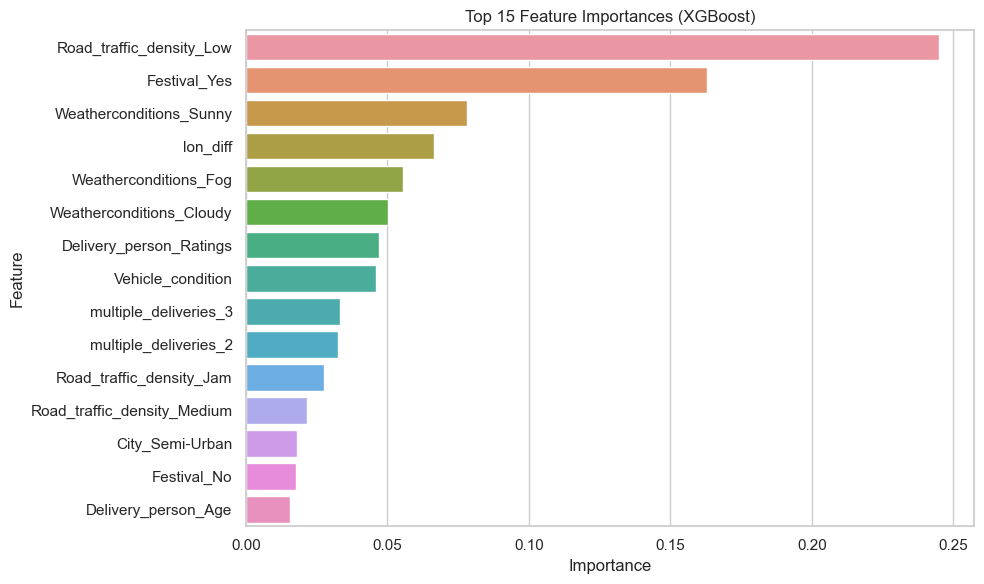

,Feature,Importance
14,Road_traffic_density_Low,0.245017
31,Festival_Yes,0.162954
10,Weatherconditions_Sunny,0.078197
42,lon_diff,0.066390
6,Weatherconditions_Fog,0.055398
5,Weatherconditions_Cloudy,0.050052
38,Delivery_person_Ratings,0.047213
39,Vehicle_condition,0.046021
3,multiple_deliveries_3,0.033420
2,multiple_deliveries_2,0.032374


In [36]:
# Define features and target
features_extended = [
    'Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition',
    'multiple_deliveries', 'distance_km', 'lat_diff', 'lon_diff',
    'Weatherconditions', 'Road_traffic_density', 'Type_of_order', 'Type_of_vehicle',
    'City', 'Festival', 'order_hour', 'order_dayofweek', 'is_lunch_peak',
    'is_dinner_peak', 'is_weekend', 'is_short_range', 'lat_bucket'
]
target = 'Time_taken(min)'

X = df_clean[features_extended]
y = df_clean[target]

# Categorical columns to be one-hot encoded
categorical_features_ext = [
    'multiple_deliveries', 'Weatherconditions', 'Road_traffic_density', 'Type_of_order',
    'Type_of_vehicle', 'City', 'Festival', 'lat_bucket'
]

# One-hot encode categoricals, passthrough everything else
preprocessor_ext = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_ext)],
    remainder='passthrough'
)

# XGBoost pipeline
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_ext),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Basic grid search for tuning
param_grid = {
    'regressor__n_estimators': [500],
    'regressor__max_depth': [8],
    'regressor__learning_rate': [0.05]
}

grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=3, scoring='r2', verbose=3)
grid_search.fit(X, y)

# Evaluate model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"MAE: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")
print(f"Best Parameters: {grid_search.best_params_}")

# Get feature importances
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']
encoded_cols = ohe.get_feature_names_out(categorical_features_ext).tolist()
feature_names = encoded_cols + [f for f in features_extended if f not in categorical_features_ext]

importances = best_model.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

feature_importance_df.head(15)

#### 📌 Insight

XGBoost, combined with rich feature engineering, slightly improves the model’s performance. The R² increases to 0.89, with the model benefitting from better handling of non-linear relationships and interactions.

Key improvements:
- Geospatial decomposition (`lat_diff`, `lon_diff`, `lat_bucket`)
- Temporal flags (`is_lunch_peak`, `is_weekend`, etc.)
- XGBoost generally outperforming Random Forest

While the boost is modest, this refined model is more interpretable and robust for real-world use. Further gains may require external data (e.g., live traffic, courier routing).

### 7. Deep Learning Model (PyTorch)

In [37]:
# Re-define X and y from df_clean and split
X = df_clean[features_extended]
y = df_clean[target]
X_encoded = pd.get_dummies(X, columns=categorical_features_ext, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to tensors for PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Now retry deeper FNN with standardized target
y_scaled = StandardScaler()
y_train_scaled = y_scaled.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = y_scaled.transform(y_test.values.reshape(-1, 1)).flatten()

y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define FNN
class FNN(nn.Module):
    def __init__(self, input_dim):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

model = DeeperFNN(X_train_tensor.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train loop
for epoch in range(100):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()

# Evaluate
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test_tensor).squeeze().numpy()
    y_pred = y_scaled.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

mae_scaled = mean_absolute_error(y_test, y_pred)
r2_scaled = r2_score(y_test, y_pred)

print(f"MAE: {mae_scaled:.2f}")
print(f"R^2 Score: {r2_scaled:.2f}")

MAE: 3.55
R^2 Score: 0.77


#### 📌 Insight

A Feedforward Neural Network (FNN) with two hidden layers (`64 → 32`) trained with MSE loss using PyTorch produced the following results:

- **MAE:** 3.55 minutes  
- **R² Score:** 0.77

While the model performed reasonably well, it underperformed compared to our XGBoost model. This suggests that:

- **Tree-based models are better suited** for tabular datasets like this one, where feature interactions and nonlinearity are critical but not spatially structured (as in images or text).
- The FNN may have struggled with generalization despite deeper layers, possibly due to the relatively small dataset size, lack of regularization, or limited signal-to-noise ratio in some features.

Although neural networks can excel in many domains, for structured data problems like this, **XGBoost remains the more reliable choice.**
